**Seq2seq Model** 

A sequence-to-sequence model is a model that takes a sequence of items (words, letters, features of an images…etc) and outputs another sequence of items. 
The model is composed of an encoder and a decoder.

The **encoder** processes each item in the input sequence, it compiles the information it captures into a vector (called the context). After processing the entire input sequence, the encoder sends the context over to the **decoder**, which begins producing the output sequence item by item. 

The context is a vector (an array of numbers, basically) in the case of machine translation. The encoder and decoder tend to both be recurrent neural networks.

Recurrent models typically take in a sequence in the order it is written and use that to output a sequence. Each element in the sequence is associated with its step in computation time t. (i.e. if a word is in the third element, it will be computed at $ t_3 $ ). These models generate a sequence of hidden states $ h_t $, as a function of the previous hidden state $ h_{t-1} $  and the input for position t. 

The sequential nature of models like RNNs, LSTMs, GRUs does not allow for parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. In other words, if you rely on sequences and you need to know the beginning of a text before being able to compute something about the ending of it, then you can not use parallel computing. You would have to wait until the initial computations are complete. This is not good, because if your text is too long, then 1) it will take a long time for you to process it and 2) you will lose a good amount of information mentioned earlier in the text as you approach the end.  

Therefore, attention mechanisms have become critical  for sequence modeling in various tasks, allowing modeling of dependencies without caring too much about their distance in the input or output sequences.  

An attention model differs from a classic sequence-to-sequence model in two main ways:

First, the encoder passes a lot more data to the decoder. Instead of passing the last hidden state of the encoding stage, the encoder passes all the hidden states to the decoder. 

Second, an attention decoder does an extra step before producing its output. In order to focus on the parts of the input that are relevant to this decoding time step, the decoder does the following:

Look at the set of encoder hidden states it received – each encoder hidden state is most associated with a certain word in the input sentence
Give each hidden state a score, Multiply each hidden state by its softmaxed score, thus amplifying hidden states with high scores, and drowning out hidden states with low scores


__[Illustrated Seq2Seq with attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)__


**Transformer** 

The Transformer was proposed in the paper __[Attention is All You Need](https://arxiv.org/abs/1706.03762)__. 

The traditional seq2seq models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations ($x_1$, ..., $x_n$) to a sequence
of continuous representations z = ($z_1$, ..., $z_n$). Given z, the decoder then generates an output
sequence ($y_1$, ..., $y_m$) of symbols one element at a time.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder.



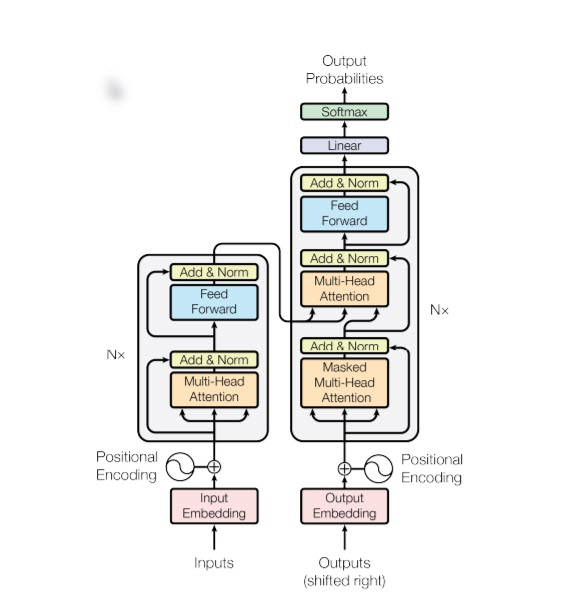

**Self-Attention at a High Level** 

Say the following sentence is an input sentence we want to translate:

The animal didn't cross the street because it was too tired.

What does “it” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.

When the model is processing the word “it”, self-attention allows it to associate “it” with “animal”.

with RNNs, it was seen how maintaining a hidden state allows an RNN to incorporate its representation of previous words/vectors it has processed with the current one it’s processing. Self-attention is the method the Transformer uses to bake the “understanding” of other relevant words into the one we’re currently processing. 


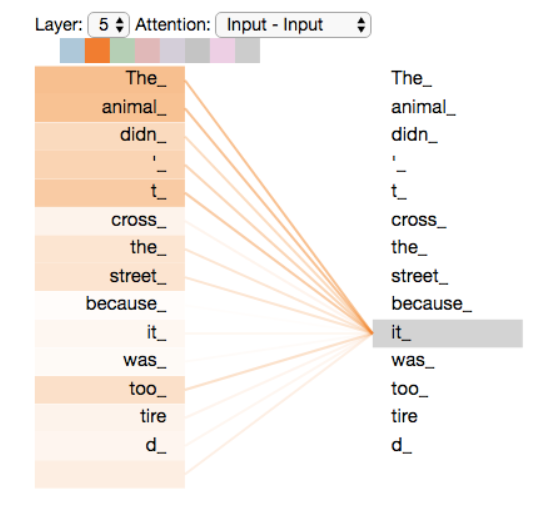

**Self-Attention**

An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key. 



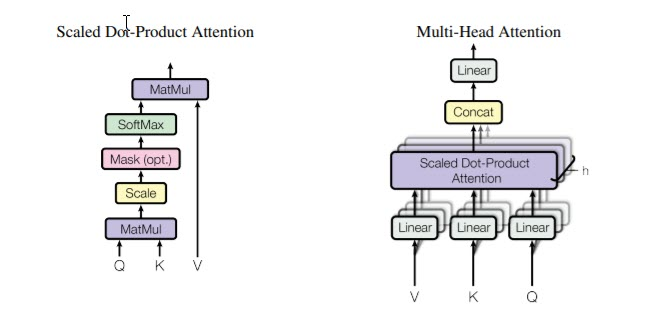

After adding all the attention heads, the encoding looks something like this:


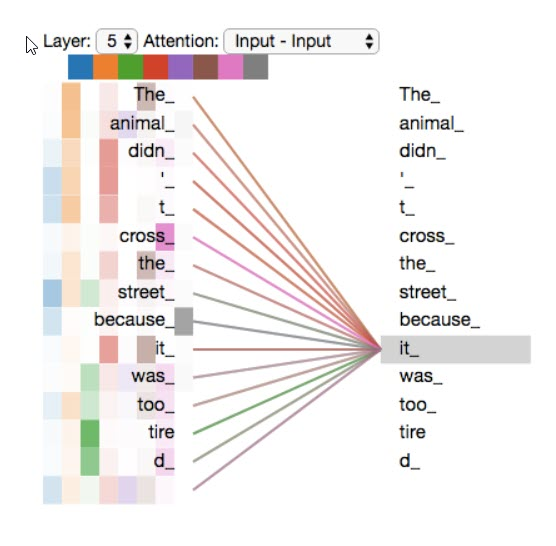

**Representing The Order of The Sequence Using Positional Encoding** 

Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. 


**Decoder**

The encoder start by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors for keys and values. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence, The following steps repeat the process until a special symbol is reached indicating the transformer decoder has completed its output. The output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. And just like we did with the encoder inputs, we embed and add positional encoding to those decoder inputs to indicate the position of each word.

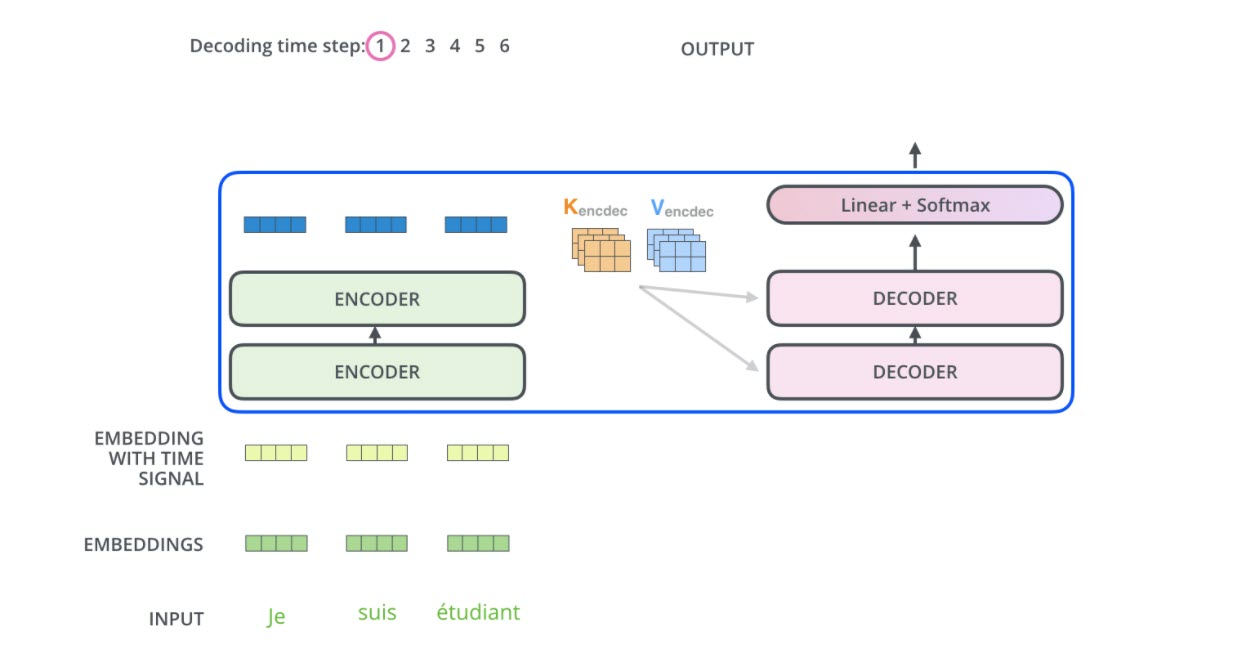

References: 

[Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

The following is an example implementation of the machine translation task with transformers in TRAX: 

In [ ]:
pip install trax

     |████████████████████████████████| 637 kB 5.2 MB/s 
     |████████████████████████████████| 4.9 MB 53.2 MB/s 


In [ ]:

# Create a Transformer model.
# Pre-trained model config in gs://trax-ml/models/translation/ende_wmt32k.gin
model = trax.models.Transformer(
    input_vocab_size=33300,
    d_model=512, d_ff=2048,
    n_heads=8, n_encoder_layers=6, n_decoder_layers=6,
    max_len=2048, mode='predict')

# Initialize using pre-trained weights.
model.init_from_file('gs://trax-ml/models/translation/ende_wmt32k.pkl.gz',
                     weights_only=True)

# Tokenize a sentence.
sentence = 'It is nice to learn new things today!'
tokenized = list(trax.data.tokenize(iter([sentence]),  # Operates on streams.
                                    vocab_dir='gs://trax-ml/vocabs/',
                                    vocab_file='ende_32k.subword'))[0]

# Decode from the Transformer.
tokenized = tokenized[None, :]  # Add batch dimension.
tokenized_translation = trax.supervised.decoding.autoregressive_sample(
    model, tokenized, temperature=0.0)  # Higher temperature: more diverse results.

# De-tokenize,
tokenized_translation = tokenized_translation[0][:-1]  # Remove batch and EOS.
translation = trax.data.detokenize(tokenized_translation,
                                   vocab_dir='gs://trax-ml/vocabs/',
                                   vocab_file='ende_32k.subword')
print(translation)

Es ist schön, heute neue Dinge zu lernen!


References: 

__[Pre-Trained Transformer](https://trax-ml.readthedocs.io/en/latest/notebooks/trax_intro.html#1.-Run-a-pre-trained-Transformer)__